<a href="https://colab.research.google.com/github/HABEEBA123344/Final_Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception

import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
from tensorflow.keras import backend as K

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.metrics import MeanIoU

# **DenseNet121**

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_densenet121_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = densenet.get_layer("input_1").output
    s2 = densenet.get_layer("conv1/relu").output
    s3 = densenet.get_layer("pool2_relu").output
    s4 = densenet.get_layer("pool3_relu").output

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

# **InceptionResnetV2**

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output

    s2 = encoder.get_layer("activation").output
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)

    s3 = encoder.get_layer("activation_3").output
    s3 = ZeroPadding2D((1, 1))(s3)

    s4 = encoder.get_layer("activation_74").output
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output
    b1 = ZeroPadding2D((1, 1))(b1)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

# **DeepLabV3+**

In [ ]:
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    base_model = Xception(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained Xception Output """
    image_features = base_model.get_layer('block14_sepconv2_act').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)
    print(x_a.shape)

    """ Get low-level features """
    x_b = base_model.get_layer('block4_sepconv2_act').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)
    print(x_b.shape)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D((8, 8), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

# **Metric**

In [ ]:
def Combo_loss(y_true, y_pred, smooth=1):

 e = K.epsilon()
 if y_pred.shape[-1] <= 1:
   ALPHA = 0.8    # < 0.5 penalises FP more, > 0.5 penalises FN more
   CE_RATIO = 0.5 # weighted contribution of modified CE loss compared to Dice loss
   y_pred = tf.keras.activations.sigmoid(y_pred)
 elif y_pred.shape[-1] >= 2:
   ALPHA = 0.3    # < 0.5 penalises FP more, > 0.5 penalises FN more
   CE_RATIO = 0.7 # weighted contribution of modified CE loss compared to Dice loss
   y_pred = tf.keras.activations.softmax(y_pred, axis=-1)
   y_true = K.squeeze(y_true, 3)
   y_true = tf.cast(y_true, "int32")
   y_true = tf.one_hot(y_true, num_class, axis=-1)

 # cast to float32 datatype
 y_true = K.cast(y_true, 'float32')
 y_pred = K.cast(y_pred, 'float32')

 targets = K.flatten(y_true)
 inputs = K.flatten(y_pred)

 intersection = K.sum(targets * inputs)
 dice = (2. * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
 inputs = K.clip(inputs, e, 1.0 - e)
 out = - (ALPHA * ((targets * K.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * K.log(1.0 - inputs))))
 weighted_ce = K.mean(out, axis=-1)
 combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)

 return combo

# **Load Dataset**

In [2]:
""" Global parameters """
H = 224
W = 224

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path,split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))
    split_size = int(3000*split)

    train_x, valid_x = train_test_split(images[:3000], test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks[:3000], test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 8
    lr = 1e-4
    num_epochs = 100
    model_path1 = os.path.join("/content/drive/MyDrive/models", "model1.h5")
    csv_path1 = os.path.join("/content/drive/MyDrive/models", "log1.csv")
    model_path2 = os.path.join("/content/drive/MyDrive/models", "model2.h5")
    csv_path2 = os.path.join("/content/drive/MyDrive/models", "log2.csv")
    model_path3 = os.path.join("/content/drive/MyDrive/models", "model3.h5")
    csv_path3 = os.path.join("/content/drive/MyDrive/models", "log3.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/cancerous_patches"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    # (train_x1, train_y1) = (train_x[:500],train_y[:500])
    # (train_x2, train_y2) = (train_x[500:1000],train_y[500:1000])
    # (train_x3, train_y3) = (train_x[1000:1500],train_y[1000:1500])

    print(f"Train1: {len(train_x)} - {len(train_y)}")
    # print(f"Train2: {len(train_x2)} - {len(train_y2)}")
    # print(f"Train3: {len(train_x3)} - {len(train_y3)}")

    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    # train_dataset2 = tf_dataset(train_x2, train_y2, batch=batch_size)
    # train_dataset3 = tf_dataset(train_x3, train_y3, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

Train1: 1800 - 1800
Valid: 600 - 600
Test : 600 - 600


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Training**

**Model 1**

In [ ]:
input_shape = (224, 224, 3)
model1 = build_densenet121_unet(input_shape)

model1.compile(loss=Combo_loss, optimizer=Adam(lr), metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(model_path1, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path1),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

history1=model1.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/100
450/450 [==============================] - ETA: 0s - loss: -0.2102 - accuracy: 0.7563
Epoch 1: val_loss improved from inf to -0.21297, saving model to /content/drive/MyDrive/models/model1.h5
450/450 [==============================] - 737s 1s/step - loss: -0.2102 - accuracy: 0.7563 - val_loss: -0.2130 - val_accuracy: 0.7176 - lr: 1.0000e-04
Epoch 2/100
450/450 [==============================] - ETA: 0s - loss: -0.2188 - accuracy: 0.8007
Epoch 2: val_loss improved from -0.21297 to -0.21619, saving model to /content/drive/MyDrive/models/model1.h5
450/450 [==============================] - 96s 212ms/step - loss: -0.2188 - accuracy: 0.8007 - val_loss: -0.2162 - val_accuracy: 0.8245 - lr: 1.0000e-04
Epoch 3/100
450/450 [==============================] - ETA: 0s - loss: -0.2225 - accuracy: 0.8229
Epoch 3: val_loss improved from -0.21619 to -0.21965, saving model to /content/drive/MyDrive/models/model1.h5
450/450 [===

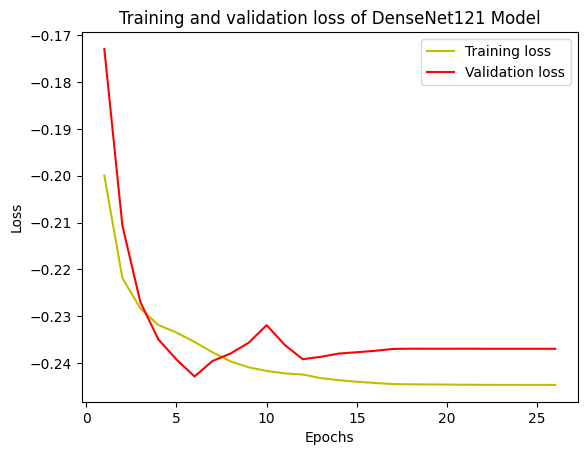

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss of DenseNet121 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

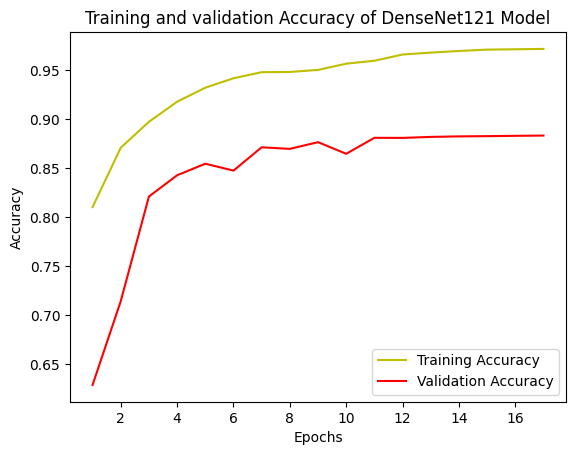

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy of DenseNet121 Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Model2**

In [ ]:
input_shape = (224, 224, 3)
model2 = build_inception_resnetv2_unet(input_shape)

model2.compile(loss=Combo_loss, optimizer=Adam(lr), metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(model_path2, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path2),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

history2=model2.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: -0.2142 - accuracy: 0.7544
Epoch 1: val_loss improved from inf to -0.21821, saving model to /content/drive/MyDrive/models/model2.h5
225/225 [==============================] - 203s 440ms/step - loss: -0.2142 - accuracy: 0.7544 - val_loss: -0.2182 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: -0.2262 - accuracy: 0.8265
Epoch 2: val_loss improved from -0.21821 to -0.22012, saving model to /content/drive/MyDrive/models/model2.h5
225/225 [==============================] - 104s 461ms/step - loss: -0.2262 - accuracy: 0.8265 - val_loss: -0.2201 - val_accuracy: 0.8051 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: -0.2309 - accuracy: 0.8553
Epoch 3: val_loss did not improve from -0.22012
225/225 [==============================] - 93s 414ms/step - loss: -0.2309 - accuracy: 0.8553 - val_loss: -0.2191 - val_accuracy: 0.7577

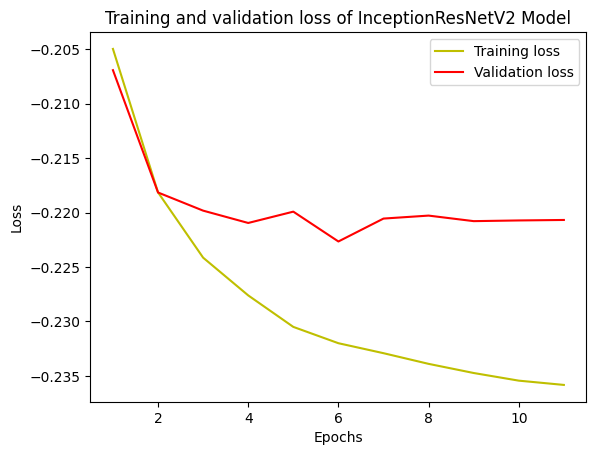

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss of InceptionResNetV2 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

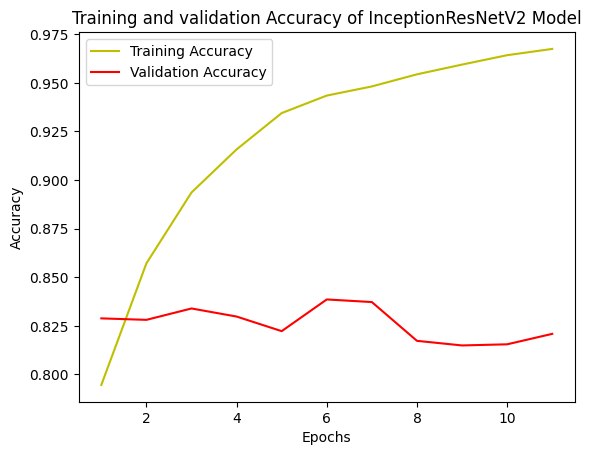

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy of InceptionResNetV2 Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Model3**

In [ ]:
input_shape = (224, 224, 3)
model3 = DeepLabV3Plus(input_shape)
model3.summary()
model3.compile(loss=Combo_loss, optimizer=Adam(lr), metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(model_path3, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path3),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
]

history3 = model3.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

(None, 28, 28, 256)
(None, 28, 28, 48)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                    

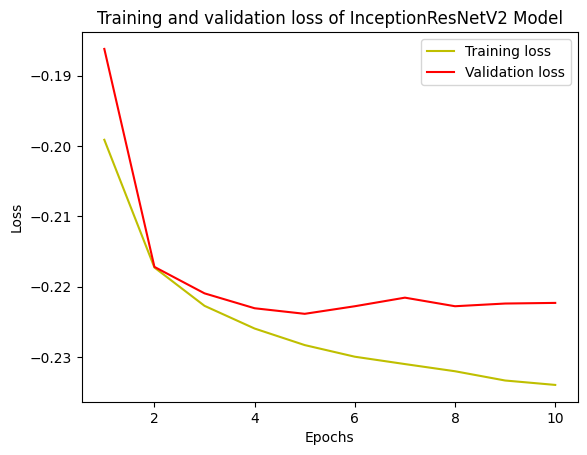

In [ ]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss of InceptionResNetV2 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

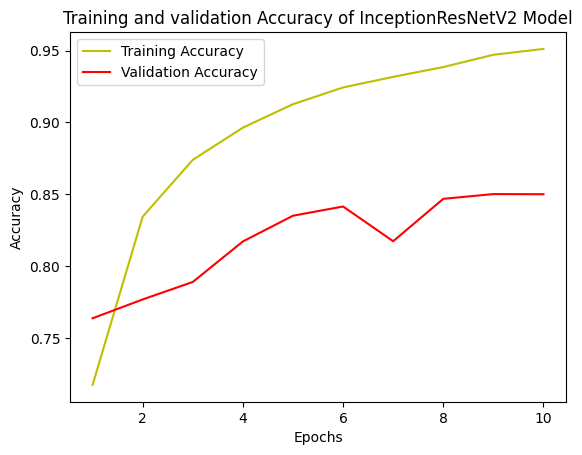

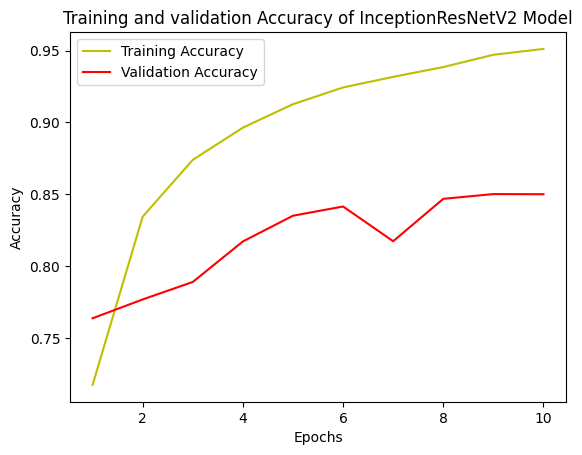

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy of InceptionResNetV2 Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Testing**

In [ ]:
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


def test(model,result_path):

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x[:20], test_y[:20]), total=len(test_y[:20])):

        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join(result_path, name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv(os.path.join(result_path,"score.csv"))

**DenseNet121**

In [ ]:
create_dir("/content/drive/MyDrive/models/results")

with CustomObjectScope({"Combo_loss": Combo_loss}):
  model1 = load_model('/content/drive/MyDrive/models/model1.h5', compile=False)

result_path1="/content/drive/MyDrive/models/results"
test(model1,result_path1)

100%|██████████| 20/20 [00:04<00:00,  4.33it/s]

F1: 0.82394
Jaccard: 0.72929
Recall: 0.94804
Precision: 0.76773


**Non-Cancerous**

In [ ]:

def save_results(image, y_pred, save_image_path):

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/dataset/non3")

    """ Dataset """
    path = "/content/drive/MyDrive/dataset/non-cancer"
    images = sorted(glob(os.path.join(path, "*.png")))

    """ Prediction and Evaluation """
    for x in tqdm(images, total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Prediction """
        y_pred = model3.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join("/content/drive/MyDrive/dataset/non3", name)
        save_results(image, y_pred, save_image_path)

100%|██████████| 5/5 [00:00<00:00, 10.24it/s]


**InceptionResNetV2**

In [ ]:
create_dir("/content/drive/MyDrive/models/results2")

with CustomObjectScope({"Combo_loss": Combo_loss}):
  model2 = load_model('/content/drive/MyDrive/models/model2.h5', compile=False)

result_path2="/content/drive/MyDrive/models/results2"
test(model2,result_path2)

100%|██████████| 20/20 [00:19<00:00,  1.02it/s]

F1: 0.79515
Jaccard: 0.69304
Recall: 0.92880
Precision: 0.72767


**DeepLabV3+**

In [ ]:
create_dir("/content/drive/MyDrive/dataset/results3")

with CustomObjectScope({"Combo_loss": Combo_loss}):
  model3 = load_model('/content/drive/MyDrive/dataset/model3.h5', compile=False)

result_path3="/content/drive/MyDrive/dataset/results3"
test(model3,result_path3)

100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


F1: 0.78379
Jaccard: 0.69005
Recall: 0.83589
Precision: 0.80512


# **Ensemble**

In [ ]:
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


def ensemble_model(result_path):

    with CustomObjectScope({"Combo_loss": Combo_loss}):
      model1 = load_model('/content/drive/MyDrive/dataset/model1.h5', compile=False)
      model2 = load_model('/content/drive/MyDrive/dataset/model2.h5', compile=False)
      model3 = load_model('/content/drive/MyDrive/dataset/model3.h5', compile=False)

    models = [model1,model2,model3]
    weights = [0.5, 0.3, 0.2]

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):

        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        preds = [model.predict(x,verbose=0)[0] for model in models]
        preds=np.array(preds)
        y_pred = np.tensordot(preds, weights, axes=((0),(0)))
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)
        print(y_pred)
        """ Saving the prediction """
        save_image_path = os.path.join(result_path, name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv(os.path.join(result_path,"score.csv"))

In [ ]:
create_dir("/content/drive/MyDrive/dataset/ens")
result="/content/drive/MyDrive/dataset/ens"

ensemble_model(result)

  5%|▌         | 1/20 [00:06<02:00,  6.36s/it]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


 10%|█         | 2/20 [00:06<00:51,  2.84s/it]

[[1 1 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 [1 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


 15%|█▌        | 3/20 [00:07<00:29,  1.72s/it]

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


 20%|██        | 4/20 [00:07<00:19,  1.19s/it]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


 25%|██▌       | 5/20 [00:07<00:13,  1.11it/s]

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


 30%|███       | 6/20 [00:08<00:10,  1.38it/s]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


 35%|███▌      | 7/20 [00:08<00:08,  1.61it/s]

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


 40%|████      | 8/20 [00:09<00:06,  1.82it/s]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


 45%|████▌     | 9/20 [00:09<00:05,  2.00it/s]

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


 50%|█████     | 10/20 [00:09<00:04,  2.13it/s]

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


 55%|█████▌    | 11/20 [00:10<00:03,  2.28it/s]

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


 60%|██████    | 12/20 [00:10<00:03,  2.34it/s]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


 65%|██████▌   | 13/20 [00:11<00:02,  2.35it/s]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


 70%|███████   | 14/20 [00:11<00:02,  2.19it/s]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


 75%|███████▌  | 15/20 [00:12<00:02,  2.04it/s]

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


 80%|████████  | 16/20 [00:12<00:02,  1.91it/s]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


 85%|████████▌ | 17/20 [00:13<00:01,  1.86it/s]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


 90%|█████████ | 18/20 [00:13<00:01,  1.82it/s]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


 95%|█████████▌| 19/20 [00:14<00:00,  1.81it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
F1: 0.76726
Jaccard: 0.68615
Recall: 0.78720
Precision: 0.84260
